In [ ]:
from matplotlib import pyplot as plt 
import torch
import numpy as np
X = torch.arange(-8,8,0.1,requires_grad=True)
y = torch.relu(X)
y.backward(torch.ones_like(X),retain_graph=True)#在自动求导中，计算梯度需要一个初始值，这个初始值通常是一个标量，但有些情况下需要一个张量。在这种情况下，torch.ones_like(x) 可以方便地创建一个与张量 x 形状相同的张量，且所有元素均为 1，作为计算梯度的初始值。
y_grad = X.grad
plt.figure(figsize=(8,3))# 先设置大小
plt.subplot(1,2,1)
plt.xlabel('x')
plt.ylabel('relu')
plt.title("relu function showing")
plt.grid()
plt.plot(X.detach(),y.detach())
plt.subplot(1,2,2)
plt.xlabel('x')
plt.ylabel('relu grad')
plt.title("relu grad showing")
plt.grid()
plt.plot(X.detach(),y_grad)

plt.show()


## 多层感知机的从零开始实现

In [ ]:
import torch
from torch import nn
import gxl_tools
from gxl_tools import  plt 
batch_size = 256
train_iter,test_iter = gxl_tools.load_data_iter_of_fashion_mnist(batch_size=batch_size)
num_input,num_output,num_hidden = 784,10,256
W1 = nn.Parameter(torch.randn(num_input,num_hidden,requires_grad=True)*0.01)#torch.randn生成的这些随机数字满足标准正态分布
b1 = nn.Parameter(torch.zeros(num_hidden,requires_grad=True))
W2 = nn.Parameter(torch.randn(num_hidden,num_output,requires_grad=True))#nn.Parameter=nn.parameter.Parameterparameter本质仍然是一个tensor。nn.Parameter的作用是：将一个不可训练的类型Tensor转换成可以训练的类型parameter，并且会向宿主模型注册该参数，成为一部分。即model.parameters()会包含这个parameter。从而，在参数优化的时候可以自动一起优化，这就不需要我们单独对这个参数进行优化啦。
b2 = nn.Parameter(torch.zeros(num_output,requires_grad=True))
params = [W1,b1,W2,b2]
def myRelu(X):
    a = torch.zeros_like(X)
    return torch.max(a,X)
def net(X):
    X = X.reshape((-1,num_input))
    H = myRelu(X@W1 + b1)
    return gxl_tools.softmax_equation((H@W2 + b2))
W11 = nn.Parameter(torch.randn(num_input,num_hidden,requires_grad=True)*0.01)#torch.randn生成的这些随机数字满足标准正态分布
b11 = nn.Parameter(torch.zeros(num_hidden,requires_grad=True))
W22 = nn.Parameter(torch.randn(num_hidden,num_output,requires_grad=True))#nn.Parameter=nn.parameter.Parameterparameter本质仍然是一个tensor。nn.Parameter的作用是：将一个不可训练的类型Tensor转换成可以训练的类型parameter，并且会向宿主模型注册该参数，成为一部分。即model.parameters()会包含这个parameter。从而，在参数优化的时候可以自动一起优化，这就不需要我们单独对这个参数进行优化啦。
b22 = nn.Parameter(torch.zeros(num_output,requires_grad=True))
params1 = [W11,b11,W22,b22]
def net1(X):
    X = X.reshape((-1,num_input))
    H = myRelu(X@W11 + b11)
    return (H@W22 + b22) 
loss = nn.CrossEntropyLoss(reduction='none')
updater = torch.optim.SGD(params=params,lr = 0.1)
updater1 = torch.optim.SGD(params=params1,lr = 0.1)
epochs = 10
# gxl_tools.train_for_some_epoch(epoch_num=epochs,net=net,loss=loss,optimizer=updater,train_iter=train_iter,test_iter=test_iter)
gxl_tools.train_for_some_epoch(epoch_num=epochs,net=net1,loss=loss,optimizer=updater1,train_iter=train_iter,test_iter=test_iter)





In [ ]:
gxl_tools.predict_for_mnist_in_ch3(net,test_iter)

## 多层感知机的简洁实现

In [ ]:
import torch
from torch import nn
import gxl_tools
net = nn.Sequential(nn.Flatten(),nn.Linear(784,256),nn.ReLU(),nn.Linear(256,10))
def weights_init(m):
    if(type(m)==nn.Linear):
        m.weight.data.normal_(std=0.01)# 标准差为0.01
net.apply(weights_init)
loss = nn.CrossEntropyLoss(reduction='none')
lr = 0.1 
batch_size = 256
epochs = 10
optimizer = torch.optim.SGD(net.parameters(),lr)
train_iter , test_iter = gxl_tools.load_data_iter_of_fashion_mnist(batch_size=batch_size)
gxl_tools.train_for_some_epoch(epochs,net,loss,optimizer,train_iter,test_iter)

## 多项式回归

In [ ]:
import numpy as np
print(np.arange(20))
print(np.arange(20).reshape(1,-1))

In [ ]:
import numpy as np
import torch 
import torch.nn as nn
import math
import gxl_tools
import matplotlib.pyplot as plt
from IPython import display

max_degree = 20
train_num,test_num=100,100
true_w= np.zeros(max_degree)
true_w[:4] = np.array([5,1.2,-3.4,5.6])
features = np.random.normal(size=(train_num+test_num,1))
np.random.shuffle(features)
poly_feattures = np.power(features,np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
    poly_feattures[:,i]/=math.gamma(i+1) # gamma(n) = (n-1)!
labels = np.dot(poly_feattures,true_w)
labels += np.random.normal(scale=0.1,size=labels.shape)
true_w,features,poly_feattures,labels = [torch.tensor(a,dtype=torch.float32) for a in [true_w,features,poly_feattures,labels]]
# 训练 正拟合
train_iter = gxl_tools.load_data_iter_by_dataarrays_by_frame((poly_feattures[:train_num,:4],labels[:train_num].reshape(-1,1)),10)#reshape(-1,1)变成二维矩阵,非常重要
test_iter = gxl_tools.load_data_iter_by_dataarrays_by_frame((poly_feattures[train_num:,:4],labels[train_num:].reshape(-1,1)),10,False)
net = nn.Sequential(nn.Linear(4,1,bias=False))
def weights_init(m):
    if(type(m)==nn.Linear):
        m.weight.data.normal_(0,0.01)
net.apply(weights_init)
loss = nn.MSELoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(),lr = 0.1)
gxl_tools.train_for_some_epoch_for_regression(50,net,loss,optimizer,train_iter,test_iter)

In [ ]:
import numpy as np
import torch 
import torch.nn as nn
import math
import gxl_tools
import matplotlib.pyplot as plt
from IPython import display

max_degree = 20
train_num,test_num=100,100
true_w= np.zeros(max_degree)
true_w[:4] = np.array([5,1.2,-3.4,5.6])
features = np.random.normal(size=(train_num+test_num,1))
np.random.shuffle(features)
poly_feattures = np.power(features,np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
    poly_feattures[:,i]/=math.gamma(i+1) # gamma(n) = (n-1)!
    poly_feattures[:,i]
labels = np.dot(poly_feattures,true_w)
# print (torch.tensor(labels,dtype=torch.float32))
a = torch.tensor(labels,dtype=torch.float32)
b = a.reshape(-1,1)
# print (a.reshape(-1,1))
print(b.shape)

In [ ]:
print(net[0].weight.data)

In [ ]:
# 训练 欠拟合
polynomial_dimensionnality = 5
train_iter = gxl_tools.load_data_iter_by_dataarrays_by_frame((poly_feattures[:train_num,:polynomial_dimensionnality],labels[:train_num].reshape(-1,1)),10)#reshape(-1,1)变成二维矩阵,非常重要
test_iter = gxl_tools.load_data_iter_by_dataarrays_by_frame((poly_feattures[train_num:,:polynomial_dimensionnality],labels[train_num:].reshape(-1,1)),10,False)
net = nn.Sequential(nn.Linear(polynomial_dimensionnality,1,bias=False))
def weights_init(m):
    if(type(m)==nn.Linear):
        m.weight.data.normal_(0,0.01)
net.apply(weights_init)
loss = nn.MSELoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(),lr = 0.1)
gxl_tools.train_for_some_epoch_for_regression(50,net,loss,optimizer,train_iter,test_iter)

In [ ]:
import numpy as np
import torch 
import torch.nn as nn
import math
import gxl_tools
import matplotlib.pyplot as plt
from IPython import display
def train_polynomial_example(train_dim=4,true_dim=4,the_true_w=[3.14,6.28,5,4],max_degree=20,train_num=100,test_num=100,batch_size=10,epochs=20,learn_rate=0.1):
    """多项式训练例子,直观展示正拟合,过拟合和欠拟合"""
    true_w= np.zeros(max_degree)
    true_w[:true_dim] = np.array(the_true_w)
    features = np.random.normal(size=(train_num+test_num,1))
    np.random.shuffle(features)
    poly_feattures = np.power(features,np.arange(max_degree).reshape(1,-1))
    for i in range(max_degree):
        poly_feattures[:,i]/=math.gamma(i+1) # gamma(n) = (n-1)!
    labels = np.dot(poly_feattures,true_w)
    labels += np.random.normal(scale=0.1,size=labels.shape)
    true_w,features,poly_feattures,labels = [torch.tensor(a,dtype=torch.float32) for a in [true_w,features,poly_feattures,labels]]
    # 训练
    train_iter = gxl_tools.load_data_iter_by_dataarrays_by_frame((poly_feattures[:train_num,:train_dim],labels[:train_num].reshape(-1,1)),batch_size)#reshape(-1,1)变成二维矩阵,非常重要
    test_iter = gxl_tools.load_data_iter_by_dataarrays_by_frame((poly_feattures[train_num:,:train_dim],labels[train_num:].reshape(-1,1)),batch_size,False)
    net = nn.Sequential(nn.Linear(train_dim,1,bias=False))
    def weights_init(m):
        if(type(m)==nn.Linear):
            m.weight.data.normal_(0,0.01)
    net.apply(weights_init)
    loss = nn.MSELoss(reduction='none')
    optimizer = torch.optim.SGD(net.parameters(),lr = learn_rate)
    gxl_tools.train_for_some_epoch_for_regression(epochs,net,loss,optimizer,train_iter,test_iter)
    print(net[0].weight.data)

def test():
    max_degree = 20
    train_num,test_num=100,100
    true_w= np.zeros(max_degree)
    true_w[:4] = np.array([5,1.2,-3.4,5.6])
    features = np.random.normal(size=(train_num+test_num,1))
    np.random.shuffle(features)
    poly_feattures = np.power(features,np.arange(max_degree).reshape(1,-1))
    for i in range(max_degree):
        poly_feattures[:,i]/=math.gamma(i+1) # gamma(n) = (n-1)!
    labels = np.dot(poly_feattures,true_w)
    labels += np.random.normal(scale=0.1,size=labels.shape)
    true_w,features,poly_feattures,labels = [torch.tensor(a,dtype=torch.float32) for a in [true_w,features,poly_feattures,labels]]
    # 训练 正拟合
    train_iter = gxl_tools.load_data_iter_by_dataarrays_by_frame((poly_feattures[:train_num,:4],labels[:train_num].reshape(-1,1)),10)#reshape(-1,1)变成二维矩阵,非常重要
    test_iter = gxl_tools.load_data_iter_by_dataarrays_by_frame((poly_feattures[train_num:,:4],labels[train_num:].reshape(-1,1)),10,False)
    net = nn.Sequential(nn.Linear(4,1,bias=False))
    def weights_init(m):
        if(type(m)==nn.Linear):
            m.weight.data.normal_(0,0.01)
    net.apply(weights_init)
    loss = nn.MSELoss(reduction='none')
    optimizer = torch.optim.SGD(net.parameters(),lr = 0.1)
    gxl_tools.train_for_some_epoch_for_regression(20,net,loss,optimizer,train_iter,test_iter)
train_polynomial_example(4,epochs=10)
# test()


In [ ]:
import gxl_tools
gxl_tools.train_polynomial_example(8,train_num=100,test_num=100,epochs=40,learn_rate=0.01)

In [ ]:
gxl_tools.train_polynomial_example(4,train_num=100,test_num=100,epochs=40,learn_rate=0.01)

In [ ]:
import gxl_tools
gxl_tools.train_polynomial_example(2)

## ⾼维线性回归
通过⼀个简单的例⼦来演⽰权重衰减

## 从零开始实现权重衰减
下⾯我们将从头开始实现权重衰减，只需将L2的平⽅惩罚添加到原始⽬标函数中。

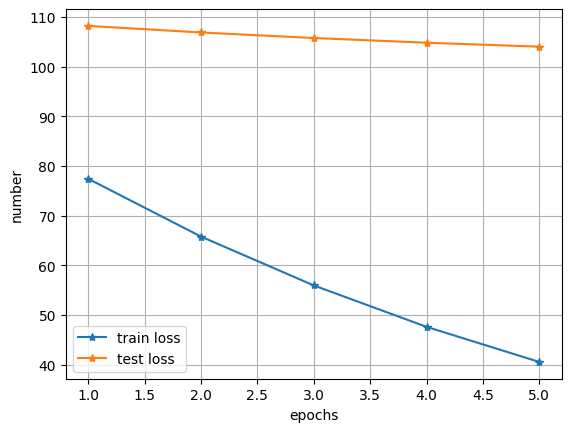

w的范数为:13.615067481994629


In [7]:
import torch 
import torch.nn as nn 
import gxl_tools

def get_data_iter_of_train_and_test():
    n_trian,n_test,input_num,batch_size=20,100,200,5
    true_w = torch.ones(input_num)*0.01
    true_b = 0.05
    train_dataarrays = gxl_tools.make_data_by_parameters_for_linear(true_w,true_b,n_trian)
    test_dataarrays = gxl_tools.make_data_by_parameters_for_linear(true_w,true_b,n_test)
    train_iter = gxl_tools.load_data_iter_by_dataarrays_by_frame(train_dataarrays,batch_size)
    test_iter = gxl_tools.load_data_iter_by_dataarrays_by_frame(test_dataarrays,batch_size)
    return train_iter,test_iter

def init_params(input_num,output):
    w = torch.normal(0,1,size=(input_num,output),requires_grad=True)
    b = torch.zeros(output,requires_grad=True)
    return w,b

def penalty(w):
    return torch.sum(w.pow(2))/2


def train(lambd=0):
    w,b = init_params(200,1)
    lr = 0.002
    epochs = 5
    net = gxl_tools.line_mode(w,b)
    loss = gxl_tools.squared_loss
    optimizer = gxl_tools.sgd((w,b),lr)
    animator = gxl_tools.Animator()
    train_iter,test_iter = get_data_iter_of_train_and_test()
    """测试权重衰减"""
    for epoch in range(epochs):
        for X,y in train_iter:
            y_hat = net(X)
            l = loss(y_hat,y) + lambd*penalty(w)
            l.mean().backward()
            optimizer()
        # if (epoch+1)%5 ==0:
        animator.add_dynamic(epoch+1,gxl_tools.evaluate_loss_for_net(net,loss,train_iter),gxl_tools.evaluate_loss_for_net(net,loss,test_iter))
    print(f'w的范数为:{torch.norm(w).item()}')
train(lambd=0)



In [ ]:
train(lambd=3)

In [ ]:
train(lambd=10)

## 简介实现

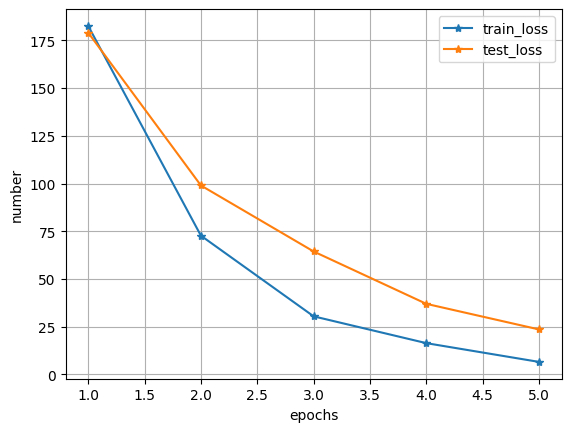

w的L2范数为:  3.9069228172302246


In [24]:
import torch 
import torch.nn as nn 
import gxl_tools
def get_data_iter_of_train_and_test(true_w = torch.ones(200)*0.01,true_b = 0.05,n_trian=20,n_test=100,batch_size=5):
    """通过true_w和ture_b生成train and test 的iter"""
    train_dataarrays = gxl_tools.make_data_by_parameters_for_linear(true_w,true_b,n_trian)
    test_dataarrays = gxl_tools.make_data_by_parameters_for_linear(true_w,true_b,n_test)
    train_iter = gxl_tools.load_data_iter_by_dataarrays_by_frame(train_dataarrays,batch_size)
    test_iter = gxl_tools.load_data_iter_by_dataarrays_by_frame(test_dataarrays,batch_size)
    return train_iter,test_iter

def init_params(input_num,output):
    w = torch.normal(0,1,size=(input_num,output),requires_grad=True)
    b = torch.zeros(output,requires_grad=True)
    return w,b

def train_for_see_damping_by_frame(wd=0,lr=0.02,epochs=5,dim=200):
    """设置权重衰减系数,通过线性函数观察效果"""
    train_iter,test_iter = get_data_iter_of_train_and_test()
    net = nn.Sequential(nn.Linear(dim,1))
    def weight_init(m):
        if(type(m)==nn.Linear):
            m.weight.data.normal_(0,1)
    net.apply(weight_init)
    loss = nn.MSELoss(reduction='none')
    optimizer = torch.optim.SGD([{'params':net[0].weight,'weight_decay':wd},{'params':net[0].bias}],lr=lr)
    gxl_tools.train_for_some_epoch_for_regression(epochs,net,loss,optimizer,train_iter,test_iter)
    print('w的L2范数为: ',net[0].weight.norm().item())
  

train_for_see_damping_by_frame(3)

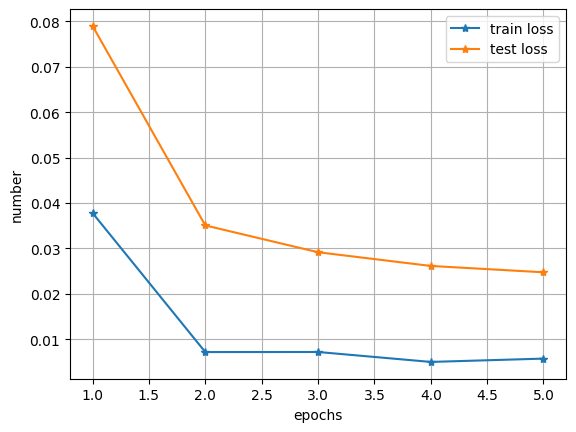

w的L2范数为:  0.042946361005306244


In [8]:
train_for_see_damping_by_frame(10)

In [14]:
import torch
import gxl_tools
a = torch.tensor([5,5,5,5,5],dtype=torch.float32)
b = torch.tensor([1,1,1,1,1],dtype=torch.float32)
loss1 = gxl_tools.squared_loss
print(loss1(a,b,action='none'))
loss = torch.nn.MSELoss(reduction='none')
print(loss(a,b))
# 我的squareLoss 和 框架的唯一差别是我除了2

tensor([8., 8., 8., 8., 8.])
tensor([16., 16., 16., 16., 16.])


In [13]:
import torch
import gxl_tools
import torch.nn as nn
a = torch.tensor([5,5,5,5,5],dtype=torch.float32)
b = torch.tensor([1,1,1,1,1],dtype=torch.float32)
w = torch.tensor([[2,3]],dtype=torch.float32)
w1 = torch.tensor([[2],[3]],dtype=torch.float32)
b = torch.tensor(4,dtype=torch.float32)
net = gxl_tools.line_mode(w,b)
X = torch.tensor([[1,1],[2,2]],dtype=torch.float32)
# net(X)
net2 = torch.nn.Sequential(torch.nn.Linear(2,1))
net2[0].weight = nn.Parameter(w)
net2[0].bias = nn.Parameter(b)
# print(net2(X))
# print(net2[0].weight)
print(w.shape)
print(w1.shape)
print(w1@w)
print(w@w1)

t1 = torch.tensor([[1,2],[2,2],[2,2]])
print(t1.shape)

net3 = nn.Sequential(nn.Linear(3,5))
print(net3[0].weight.shape)
print(net3[0].bias.shape)
# net3[0].weight.data.fill_(1)
# net3[0].bias.data.fill_(0)
# net3(torch.tensor([[1,2,3],[1,2,3],[1,2,3],[1,2,3],[1,2,3]],dtype=torch.float32))
print(net3[0].bias.data.shape)
# pytorch的线性模型的w参数正好是理论值的转置.


torch.Size([1, 2])
torch.Size([2, 1])
tensor([[4., 6.],
        [6., 9.]])
tensor([[13.]])
torch.Size([3, 2])
torch.Size([5, 3])
torch.Size([5])
torch.Size([5])


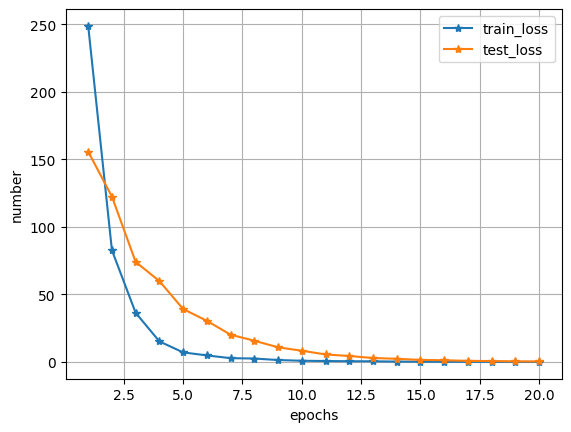

w的L2范数为:  0.4892066419124603


In [2]:
import gxl_tools
gxl_tools.train_for_see_damping_by_frame(2,epochs=20)

## 暂退法,从零开始实现
降低过拟合的第二个方法

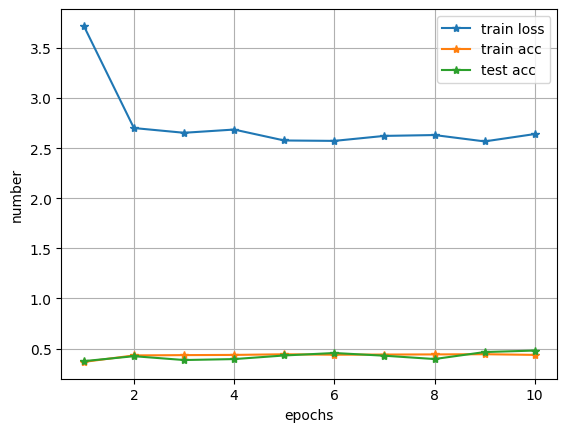

In [4]:
from typing import Iterator
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import gxl_tools

def dropout_layer(X,dropout):
    if(dropout==1):
        return torch.zeros_like(X)
    if(dropout==0):
        return X
    mask = (torch.rand(X.shape)>dropout).float()
    return (X * mask)/(1-dropout)

input_num = 784
output_num = 10
hidden1_num = 256
hidden2_num = 256

class MyDeepNet():
    """定义类时先输入输入输出参数,如果有隐藏层再以此输入各自隐藏层的输入,
    如果隐藏层想使用暂退法,则再以list的形式输入各个层的drop概率,dropsout参数必须显式声明,
    因为其前面是动态参数hiddens_input"""
    def __init__(self,input_num,output_num,*hiddens_input,dropouts=None,is_trian=True) -> None:
        self.training = is_trian
        self.dropouts = dropouts
        self.linList = []
        self.input_num = input_num
        self.output_num = output_num
        lens = len(hiddens_input)
        if lens==0:
            self.linList.append(nn.Linear(self.input_num,self.output_num))
        else:
            for i in range(lens):
                if(i==0):
                    self.linList.append(nn.Linear(self.input_num,hiddens_input[i]))
                else:
                    self.linList.append(nn.Linear(hiddens_input[i-1],hiddens_input[i]))
            self.linList.append(nn.Linear(hiddens_input[lens-1],self.output_num))
        self.relu = gxl_tools.reLU_equation
        for net in self.linList:
            net.weight.data.normal_(0,0.01)
    def __call__(self,X):
        Y = X.clone().reshape(-1,self.input_num)
        for i in range(len(self.linList)):
            if(i!= len(self.linList)-1):
                net = self.linList[i]
                Y = self.relu(net(Y))
                if(self.training==True):
                    if(self.dropouts==None):
                        Y = dropout_layer(Y,0.4)
                    else:
                        Y = dropout_layer(Y,self.dropouts[i])
            else:
                net = self.linList[i]
                Y = (net(Y))
        return Y
    def get_parameters(self):
        params = []
        for i in range(len(self.linList)):
            net = self.linList[i]
            params.append(net.weight)
            params.append(net.bias)
        return params

net = MyDeepNet(784,10,256,256,dropouts=[0.2,0.5])
train_iter,test_iter = gxl_tools.load_data_iter_of_fashion_mnist(batch_size=256)
loss = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.get_parameters(),lr = 0.5)
epochs = 10
gxl_tools.train_for_some_epoch_for_classify(epochs,net,loss,optimizer,train_iter,test_iter)




In [16]:
class Gxl:
    def __init__(self) -> None:
        pass
    def forward(self):
        print("ddd")
    def __call__(self, *args: Any, **kwds: Any) -> Any:
        self.forward()
gxl = Gxl()
gxl()

ddd


In [2]:
import gxl_tools
import torch
X = torch.tensor([[1,2,3,-3,1],[1,2,3,-4,-3]])
print(gxl_tools.reLU_equation(X))

tensor([[1., 1., 1., 0., 1.],
        [1., 1., 1., 0., 0.]])


## 暂退法 简洁实现

In [3]:
import torch.nn as nn
import torch
import sys
sys.path.append('/home/xlgeng')
import gxl_tools


net = nn.Sequential(nn.Flatten(),nn.Linear(784,256),nn.ReLU(),nn.Dropout(0.2),nn.Linear(256,256),nn.ReLU(),nn.Dropout(0.5),nn.Linear(256,10))
# net = gxl_tools.MyDeepNet(784,10,256,256,dropouts=[0.2,0.5])
optimizer = torch.optim.SGD(net.parameters(),lr=0.5)
loss = nn.CrossEntropyLoss(reduction='none')
train_iter,test_iter = gxl_tools.load_data_iter_of_fashion_mnist(256)
gxl_tools.train_for_some_epoch_for_classify(10,net,loss,optimizer,train_iter,test_iter)



ModuleNotFoundError: No module named 'gxl_tools'

## 实战Kaggle⽐赛：预测房价

In [ ]:
import hashlib
import tarfile
import zipfile
import requests
import os